In [ ]:
import os
import sys
import json
import numpy as np
import pandas as pd
import joblib

# Project setup
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

from src.utils.data_partition import temporal_split
from src.utils.visualization import plot_prediction_interval_map, plot_grid_map
from src.conformal.mapie_per_cell import apply_conformal_mapie_per_cell
from src.utils.transformations import aggregate_by_cell
from src.utils.spatial_processing import predictions_to_grid
from src.evaluation.evaluation_cp import (
                                            compute_misscoverage_per_cell,
                                            compute_overall_misscoverge,
                                            compute_interval_width_per_sample,
                                            compute_overall_interval_width,
                                            compute_spatiotemporal_confidence
                                         )
from src.evaluation.hotspot_classification import classify_temporal_hotspots, hotspot_priority, plot_hotspot_priority_map



# Load config
with open(os.path.join("..", "config.json"), "r") as f:
    config = json.load(f)

# Parameters
hotspot_percentage = config["evaluation"]["hotspot_percentage"]
grid_size = (config["data_generation"]["rows"], config["data_generation"]["cols"])



In [2]:
# Load data
df = pd.read_csv("../data/examples/poisson_example_40x40.csv")

# Partition
days_per_month = 30
train_days = config["data_partition"]["train_months"] * days_per_month
calib_days = config["data_partition"]["calibration_months"] * days_per_month
test_days = config["data_partition"]["test_months"] * days_per_month

df_train, df_calib, df_test = temporal_split(
    df,
    train_days,
    train_days + calib_days,
    train_days + calib_days + test_days
)

# Features and targets
features = ["timestep", "row", "col"]
target = "count"

X_cal = df_calib[features].copy()
y_cal = df_calib[target].copy()

X_test = df_test[features].copy()
y_test = df_test[target].copy()

# Load pre-trained model
naive_model = joblib.load("../results/models/naive_cell_model.pkl")



In [3]:
# Apply conformal prediction per cell using pre-trained model
print("Applying MAPIE per cell using pre-trained Naive model...")
y_pred, y_min, y_max = apply_conformal_mapie_per_cell(
    X_cal, y_cal, X_test,
    base_estimator=naive_model,
    alpha=0.1,
    method="plus",
    grid_size=grid_size,
    prefit=True
)

Applying MAPIE per cell using pre-trained Naive model...


Processing rows: 100%|██████████| 40/40 [00:02<00:00, 16.19it/s]


In [4]:
# Clip negative values to zero (makes sense for counts)
y_min = np.maximum(y_min, 0)

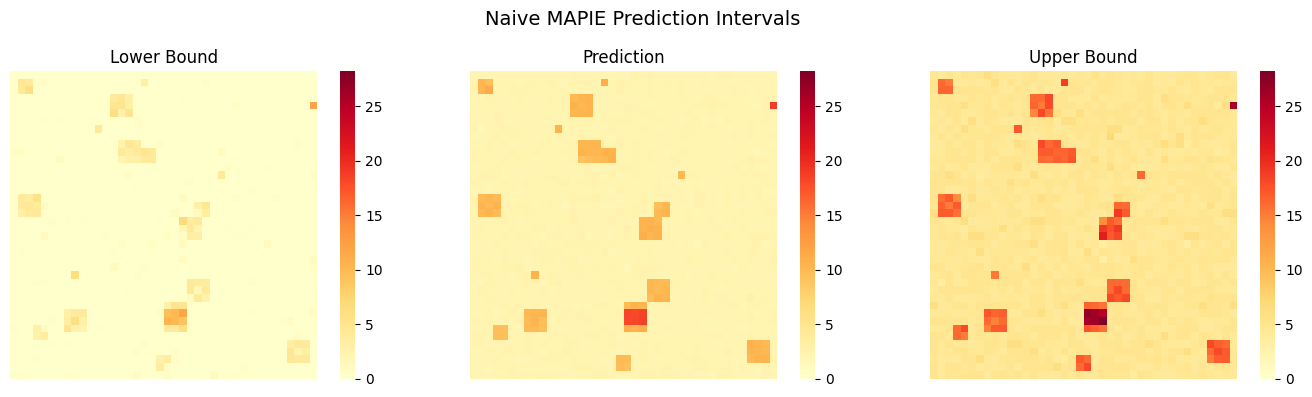

In [5]:
# Asignar predicción directamente
grid_pred = y_pred  # Ya está en formato de grilla (rows x cols)

# Convertir ground truth a grilla
grid_true = aggregate_by_cell(X_test, y_test, grid_size,aggfunc="mean")

# Visualizar intervalos de predicción
plot_prediction_interval_map(
    y_min, grid_pred , y_max,
    title="Naive MAPIE Prediction Intervals",
    titles = [ "Lower Bound","Prediction", "Upper Bound"]
)


In [6]:
grid_true, _ = predictions_to_grid(X_test, y_test, y_test, grid_size, aggregate=False)

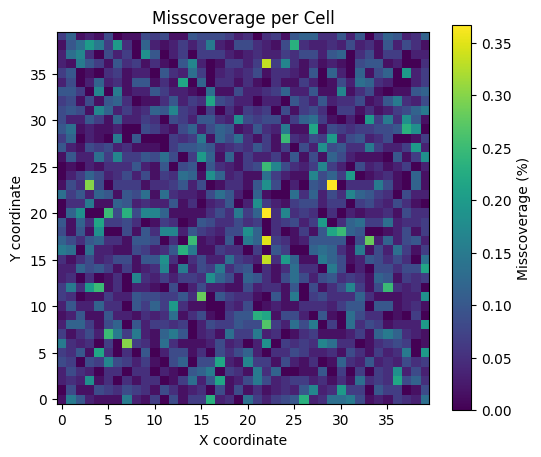

Average Misscoverage: 6.32% ± 24.33%


In [7]:
miss_coverage=compute_misscoverage_per_cell(grid_true, y_min, y_max,X_test)
misscoverage_grid, overall_misscoverage, std_misscoverage=compute_overall_misscoverge(miss_coverage)

# Visualiza cobertura por celda (Misscoverage)
plot_grid_map(misscoverage_grid, title="Misscoverage per Cell", cmap=None, label="Misscoverage (%)", vmin=0, vmax=misscoverage_grid.max())
print(f"Average Misscoverage: {100 * overall_misscoverage:.2f}% ± {100 * std_misscoverage:.2f}%")

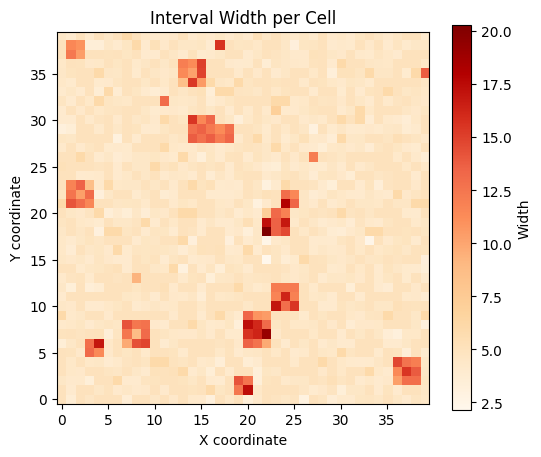

Average interval width: 5.15 ± 2.20


In [8]:
width_intervals=compute_interval_width_per_sample(np.repeat(y_min[None, :, :], test_days, axis=0),
                                                  np.repeat(y_max[None, :, :], test_days, axis=0),
                                                  X_test)
width_grid, overall_width, std_width=compute_overall_interval_width(width_intervals)


# # Visualiza tamaño de intervalo por celda
plot_grid_map(width_grid, title="Interval Width per Cell", cmap="OrRd", label="Width")
print(f"Average interval width: {overall_width:.2f} ± {std_width:.2f}")

In [9]:
miss_coverage = miss_coverage.set_index(["timestep", "row", "col"])
width_intervals = width_intervals.set_index(["timestep", "row", "col"])

df_metrics = pd.concat([miss_coverage, width_intervals], axis=1, join="inner").reset_index()

In [10]:
coverage_per_cell = (
    df_metrics.groupby(["row", "col"])["not_in_interval"]
    .apply(lambda x: x.mean())
    .reset_index(name="miss_coverage")
)

# Merge con el DataFrame original
df_metrics = df_metrics.merge(coverage_per_cell, on=["row", "col"], how="left")


In [11]:
df_metrics = df_metrics.rename(columns={
    "not_in_interval": "Outside Interval",
    "interval_width": "Interval Width",
    "miss_coverage": "Miss Rate"
})

In [12]:
df_metrics

,timestep,row,col,Outside Interval,Interval Width,Miss Rate
0,120,1,23,False,5.000000,0.033333
1,120,1,22,False,5.000000,0.016667
2,120,1,21,False,4.377778,0.050000
3,120,1,20,False,17.311111,0.016667
4,120,1,19,True,12.422222,0.083333
...,...,...,...,...,...,...
95995,179,0,11,False,5.000000,0.000000
95996,179,0,12,False,4.311111,0.083333
95997,179,0,13,False,5.000000,0.016667
95998,179,0,14,False,4.244444,0.066667


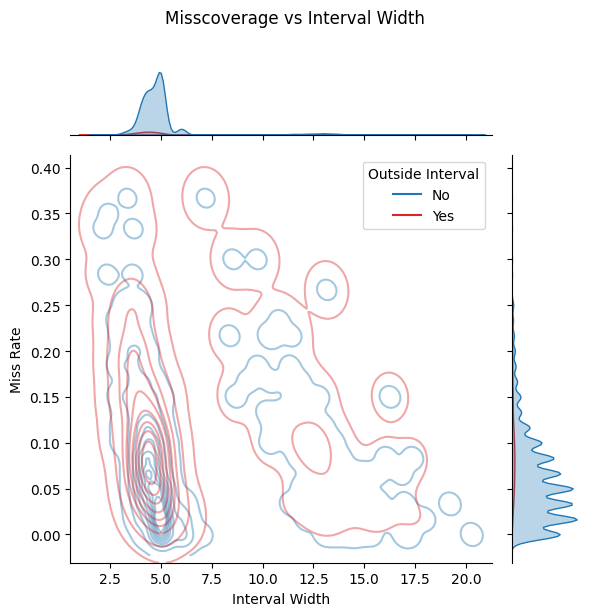

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = {
    "No": "#1f77b4",  # Azul para cobertura
    "Yes": "#d62728"    # Rojo para fuera de intervalo
}


g = sns.jointplot(
    data=df_metrics.replace({True:"Yes",False:"No"}),
    x="Interval Width",
    y="Miss Rate",
    hue="Outside Interval",
    kind="kde",
    palette=palette,
    fill=False,
    thresh=0.005,
    levels=10,
    common_norm=False,
    marginal_kws=dict(fill=True, alpha=0.3),
    joint_kws=dict(alpha=0.4)
)

g.fig.suptitle("Misscoverage vs Interval Width", y=1.02)
plt.tight_layout()
plt.show()


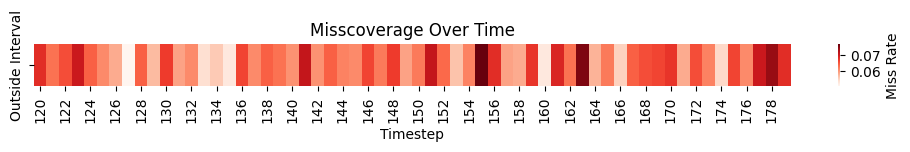

In [14]:
heatmap_data = df_metrics.groupby("timestep")["Outside Interval"].mean().to_frame()

plt.figure(figsize=(10, 1.5))
sns.heatmap(heatmap_data.T, cmap="Reds", cbar_kws={'label': 'Miss Rate'})
plt.title("Misscoverage Over Time")
plt.xlabel("Timestep")
plt.tight_layout()
plt.show()


In [15]:
hs_class = classify_temporal_hotspots(grid_true,
                                      grid_pred,
                                      hotspot_percentage)

In [16]:
real_timesteps = sorted(df_metrics["timestep"].unique())
timestep_map = {i: real_timesteps[i] for i in range(len(real_timesteps))}
hs_class["timestep"] = hs_class["timestep"].map(timestep_map)


In [17]:
df_final = pd.merge(df_metrics, hs_class, on=["timestep", "row", "col"], how="inner")
df_final = df_final.rename(columns={
    "cell_type": "Hotspot Match Type"
})

In [18]:
ssc_df=df_final.groupby("Hotspot Match Type").agg({"Outside Interval":["mean","std"]}).reset_index()
ssc_mean=ssc_df["Outside Interval"]["mean"].mean()
ssc_std=ssc_df["Outside Interval"]["std"].mean()
print(f"Size-Stratified Coverage: {ssc_mean:.2f} ± {ssc_std:.2f}")
ssc_df

Size-Stratified Coverage: 0.13 ± 0.32


Hotspot Match Type Outside Interval          
                                 mean       std
0               Both         0.143979  0.351298
1            GT-only         0.274066  0.446295
2            Neither         0.060583  0.238566
3          Pred-only         0.059066  0.235829

In [19]:
palette = {
            "Neither": "#1f77b4",
            "Pred-only": "#ff7f0e",
            "GT-only": "#d62728",
            "Both": "#2ca02c"
        }

hue_order = ["Neither", "Both", "Pred-only", "GT-only"]

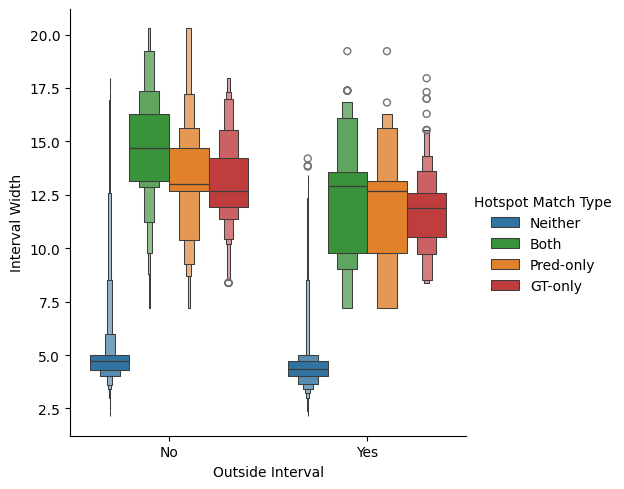

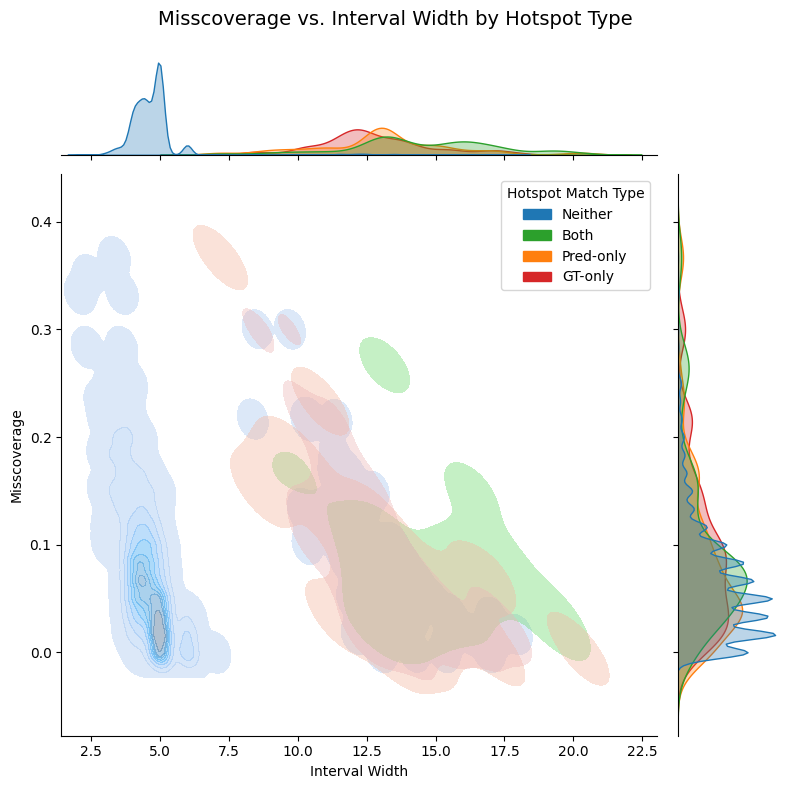

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(
    data=df_final.replace({True:"Yes",False:"No"}), x="Outside Interval", y="Interval Width", hue="Hotspot Match Type",
    kind="boxen", palette=palette,hue_order=hue_order
)

g = sns.JointGrid(
    data=df_final.replace({True:"Yes",False:"No"}),
    x="Interval Width",
    y="Miss Rate",
    hue="Hotspot Match Type",
    palette=palette,
    hue_order=hue_order,
    height=8
)

# KDE bivariado central
g.plot_joint(sns.kdeplot, fill=True, alpha=0.4, thresh=0.005)

# KDE univariados marginales
g.plot_marginals(sns.kdeplot, common_norm=False, fill=True, alpha=0.3)

# Título y ejes
g.fig.suptitle("Misscoverage vs. Interval Width by Hotspot Type", fontsize=14)
g.set_axis_labels("Interval Width", "Misscoverage")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.92)  
plt.show()

### 🔍 Confidence Metric for Hotspots

When the model predicts a cell as a hotspot, we want to estimate **how confident** it is about that prediction. To do this, we propose a metric that combines two key components:

1. **Misscoverage (1 - coverage):** measures how often the true value *did not* fall within the predicted interval.  
   - High coverage means the model has been historically reliable in that cell.
   - We use its complement (misscoverage) as an error indicator.

2. **Interval width:** captures the model's uncertainty.  
   - Wide intervals imply high uncertainty.
   - We normalize it to a [0, 1] scale for comparability.

---

#### 📐 Proposed Formula (spatio-temporal version):

Confidence(t, r, c) = 1 - NotCovered(t, r, c) - λ * NormalizedIntervalWidth(t, r, c)


Where:
- `NotCovered(t, r, c)` is 1 if the true value at time `t` and cell `(r,c)` was outside the predicted interval; otherwise 0.
- `NormalizedIntervalWidth(t, r, c)` is the width of the prediction interval at that point, scaled between its minimum and maximum values across the dataset.
- `λ` (*lambda*) is a weight ∈ [0, 1] that controls the trade-off between **interval size** and **coverage**.

The resulting score is clipped to the range `[0, 1]`, where higher values indicate **greater confidence** in the model’s hotspot prediction.

---

#### 🧠 Interpretation:

- **High confidence (~1):** the model consistently covers the true value with narrow intervals → reliable and precise.
- **Low confidence (~0):** the model frequently misses or has large uncertainty → unreliable prediction.

This metric enables **prioritization of interventions** on hotspots with stronger statistical support.



In [21]:
df_final=compute_spatiotemporal_confidence(df_final, lambda_param=0.4)
df_final

,timestep,row,col,Outside Interval,Interval Width,Miss Rate,Hotspot Match Type,width_norm,Confidence
0,120,1,23,False,5.000000,0.033333,Neither,0.157895,0.936842
1,120,1,22,False,5.000000,0.016667,Neither,0.157895,0.936842
2,120,1,21,False,4.377778,0.050000,Neither,0.123623,0.950551
3,120,1,20,False,17.311111,0.016667,Neither,0.835985,0.665606
4,120,1,19,True,12.422222,0.083333,GT-only,0.566707,0.000000
...,...,...,...,...,...,...,...,...,...
95995,179,0,11,False,5.000000,0.000000,Neither,0.157895,0.936842
95996,179,0,12,False,4.311111,0.083333,Neither,0.119951,0.952020
95997,179,0,13,False,5.000000,0.016667,Neither,0.157895,0.936842
95998,179,0,14,False,4.244444,0.066667,Neither,0.116279,0.953488


In [22]:
confidence_df=df_final.groupby(["row","col"]).agg({"Confidence":"mean"}).reset_index()
confidence_grid,_=predictions_to_grid(confidence_df, confidence_df["Confidence"], confidence_df["Confidence"],grid_size, aggregate=False)

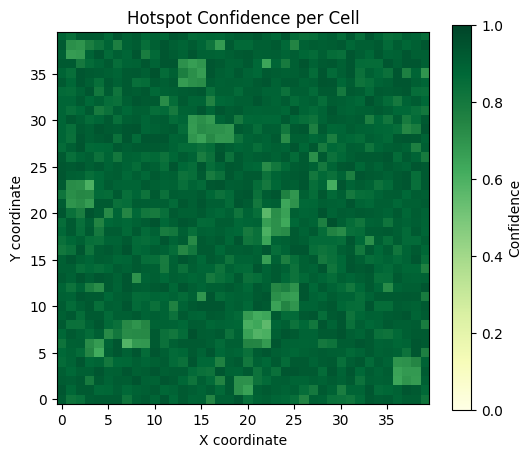

In [23]:
plot_grid_map(confidence_grid, title="Hotspot Confidence per Cell", cmap="YlGn", label="Confidence", vmin=0, vmax=1)

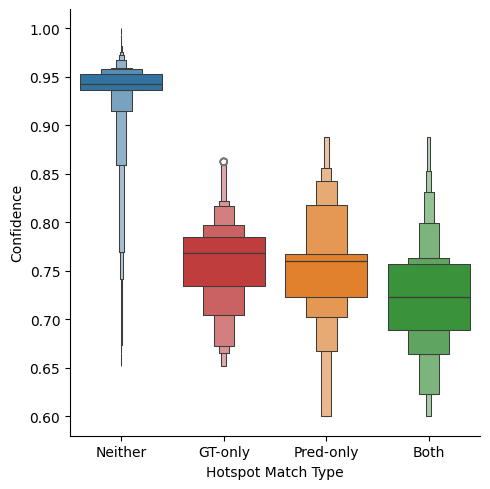

In [24]:
sns.catplot(data=df_final[~df_final["Outside Interval"]], 
            y="Confidence", x="Hotspot Match Type",
              hue="Hotspot Match Type", kind="boxen",
              palette=palette,hue_order=hue_order)

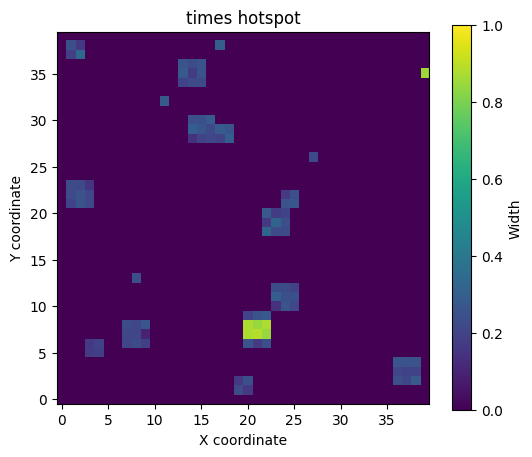

In [25]:
from src.utils.spatial_processing import define_hotspot_by_crimes
train_grid,_=predictions_to_grid(df_train, df_train["count"], df_train["count"],grid_size, aggregate=False)
true_mask=[]
for i in range(train_days):
    true_mask.append(define_hotspot_by_crimes(train_grid[i], hotspot_percentage))

true_mask=np.mean(true_mask,axis=0)
plot_grid_map(true_mask, title="times hotspot", cmap=None, label="Width",vmax=1)

In [28]:
priority_grid, legend = hotspot_priority(true_mask, confidence_grid, freq_thresh=0.7, conf_thresh=0.8)

### 🔍 **Cell Priority Classification Based on Frequency and Confidence**

| Category        | Frequency | Confidence | Color    | Interpretation                                                                 |
|----------------|-----------|-------------|----------|---------------------------------------------------------------------------------|
| 🟥 Priority     | High      | High        | Red      | Active area with high model certainty → top priority for intervention.         |
| 🟧 Critical     | High      | Low         | Orange   | Active area but uncertain → potential error or shifting hotspot.               |
| 🟨 Monitoring   | Low       | Low         | Yellow   | Inactive but uncertain → monitor for potential reactivation.                   |
| 🟩 Low Interest | Low       | High        | Green    | Calm area with high confidence → no immediate attention required.              |

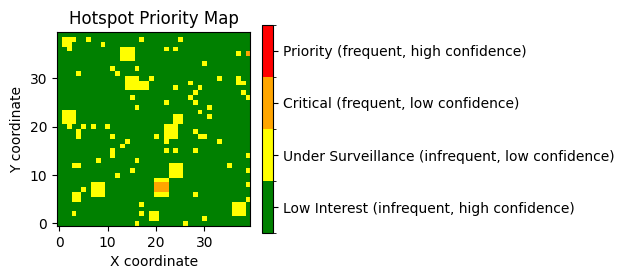

In [29]:
plot_hotspot_priority_map (priority_grid, legend)